This notebook is intended to present an application of the Baker-Campbell-Hausdorff theorem.

The time evolution of a wavefunction $\Psi$ can be written as
$$\Psi(r,t) = \exp( -\tfrac{i}{\hbar} \hat{H} t) \Psi(r,t=0),$$
where $\exp( -\tfrac{i}{\hbar} \hat{H} t)$ is the time-evolution operator $\hat{U}$ and $\Psi(r,t=0)$ the initial state. This equation becomes especially usefull if the associated eigenvalue problem $H\varphi = E\varphi$ has been solved and the initial condition $\Psi(r,t=0)$ can be expanded in the modes (eigenfunctions) $\varphi_n$ (see other notebook).

However, if the eigenvalue problem turns out to be very difficult and the considered physics involve the scattering off a localized potential V, a different approach can be taken, which is known as the split-step method.
The prototype Hamiltonian reads
$$\hat{H} = \frac{\hbar^2 \hat{p}}{2m} + \hat{V},$$
where the first term describes the kinetic energy operator $\hat{T}$ of the considered particle and the second term the potential operator. Note that kinetic energy operator is diagonal in momentum (k) space and the potential operator is diagonal in position space.

However, in the case of the time-evolution operator
$$ \hat{U}  = \exp(-\tfrac{i}{\hbar}\hat{H}t) = \exp(-\tfrac{i}{\hbar}\hat{T}t -\tfrac{i}{\hbar}\hat{V}t) $$
this fact can not be utilized, since $\hat{T}$ and $\hat{V}$ generally do not commutate. At this point, the Baker-Campbell-Hausdorff theorem comes into action: For two operators $A$ and $B$ and the scalar $t$, the following approximation can be made
$$ \exp(At+Bt) = \exp(At)\exp(Bt)\exp(-\tfrac{1}{2}[A,B]t^2) \approx \exp(At)\exp(Bt) $$
if $t$ is sufficiently small (and A und B fullfil $[A,[A,B]]=0$ and $[B,[A,B]]=0$), since the term with the commutator scales with $\exp(t^2)$.

Hence, for small time steps $\Delta t$, the wave function $\Psi$ can be advanced according to
$$ \Psi(r,t+\Delta t) =  \exp(-\tfrac{i}{\hbar}\hat{T}\Delta t) \exp(\tfrac{i}{\hbar}\hat{V}\Delta t) \Psi(r,t).$$

Applying the first exponential from the right (with the potential operator) is trivial in position space, where it is a simple algebraic multiplication. To apply the second exponential (with the kinetic energy operator), the resulting wavefunction is transformed to momentum (k) space via the Fourier transform. There the kinetic energy operator corresponds to the algebraic multiplication with $\hbar^2 k^2 / 2m$. The result is then transformed back to position space via the inverse Fourier transform, which concludes the step $\Delta t$. The complete step can be expressed as
$$ \Psi(r,t+\Delta t) =  FT^{-1}\left\{\exp(-\tfrac{i}{\hbar}\tfrac{\hbar^2 k^2 }{2m}\Delta t) FT\left\{ \exp(\tfrac{i}{\hbar}{V(x)}\Delta t) \Psi(r,t) \right\}\right\},$$
where $FT$ denotes the Fourier transform.
The split refers to the seperate application of the two operators in position and momentum space.
This procedure can the repeated to obtain the time evolution of $\Psi$ up to the desired $t$.

This algorithm can be further improved by symmetrizing the kinetic energy contribution, which yields an error that scales with $\Delta t^3$. However, for purpose of utilizing the Baker-Campbell-Hausdorff theorem, this is not done in this notebook.


The following code examplifies the split-step method in one dimension via the scattering of a gaussian wave packet off a flat-top gaussion potential.

The code is setup to keep the wave packet away from the spatial boundaries by automatically determining a maximum integration time t_max. This is import to maintain locality in this setup.

<IPython.core.display.Javascript object>


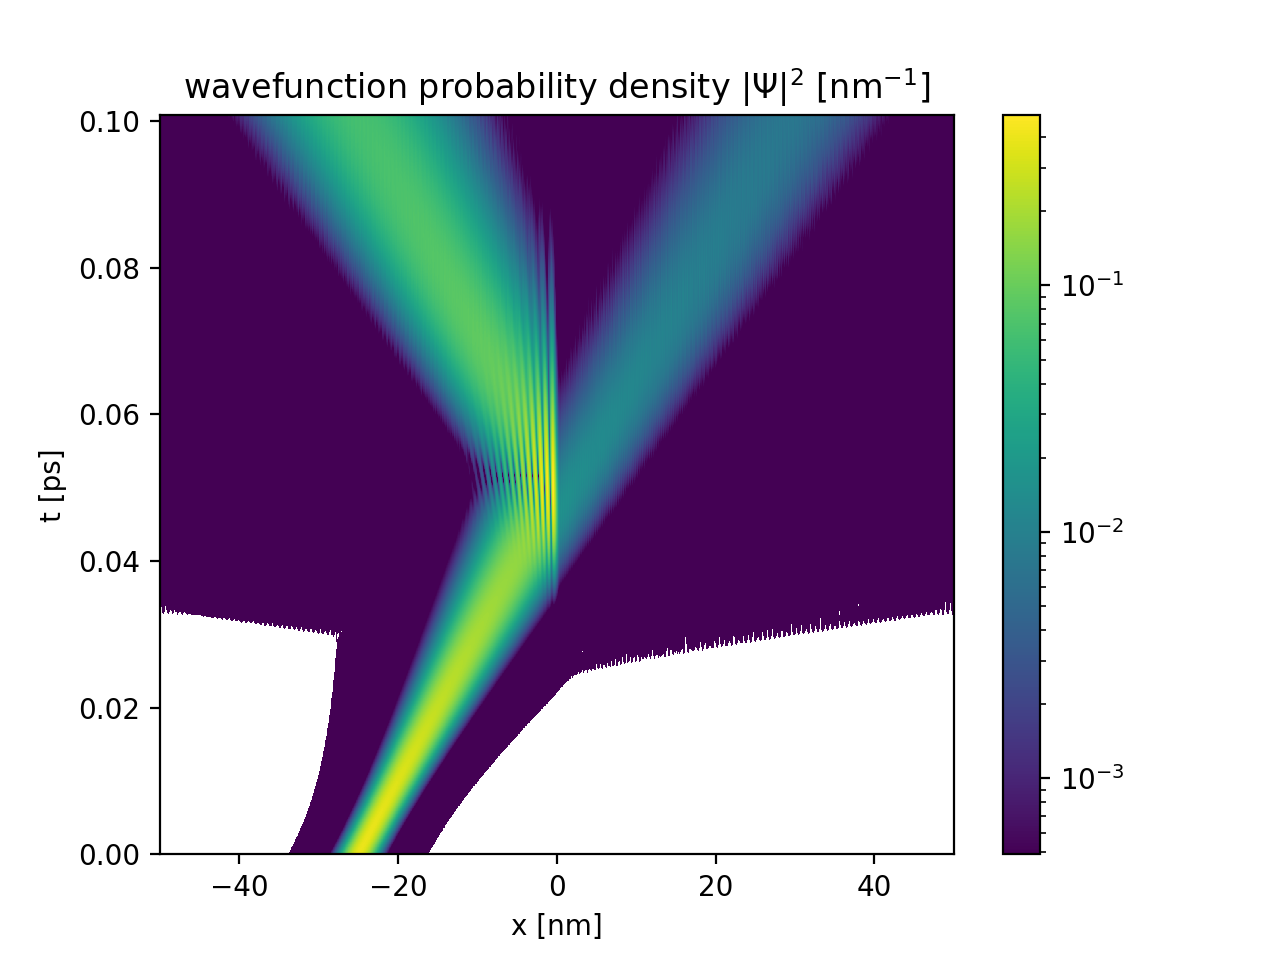

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy import constants

hbar = constants.hbar


### system parameters
L = 100e-9 #size of the box
L_bar = 0.5e-9 #size of the potential barrier
m = constants.m_e # partical mass =  electron mass

V_bar = 1.0*constants.e # potential barrier maximum in eV
eps0 = 0.7*constants.e # energy


### temporal discretization
dt = 0.1e-15

### spatial discretization
x_nmax = 2000
x_grid = np.linspace(-L/2.,L/2.,x_nmax+1)
dx = L/(x_nmax) #spatial discretization length

#corresponding k_grid
k_grid = np.fft.fftfreq(x_nmax+1, d=dx)*2.*np.pi

### kinetic energy operator in k space
T = k_grid * k_grid * hbar * hbar / (2.*m)

### potential barrier - flat top gaussian -> smooth potential changes work better the discontinous steps
# V_bar = 1.5*constants.e # potential barrier maximum in eV
Gauss_order = 4
V = V_bar * np.exp(- (0.5 * x_grid**2 / (0.5*L_bar)**2) **Gauss_order )

# #uncomment to plot potential
# plt.plot(x*1e9,V/constants.e)
# plt.xlim(-2*L_bar*1e9,2*L_bar*1e9)
# plt.show()

        

### initial conditions - gaussian wave package
x_0 = -(L/2)*0.5 #mean
sigma = L/100 #width
# eps0 = 1.0*constants.e # energy
k0 = np.sqrt(2*m*eps0/hbar/hbar) #wave vector
v0 = hbar*k0/m
# print('group velocity', v0)

init = np.zeros(x_grid.size, dtype=complex)
init = np.exp(-0.25 * (x_grid-x_0)**2 / sigma**2 ) * np.exp(1.j*k0*x_grid)
norm = (np.sum( np.abs(init)**2 )*dx)
init /= np.sqrt(norm)
# print('integrated probability density:', np.sum(np.abs(init)**2)*dx) # make sure the norm works

# #uncomment to plot initial state
# plt.plot(x*1e9,np.abs(init)**2*1e-9)
# plt.show()



# determine t_max such that the wave package does not reach the boundaries
t_max = 2.0*np.abs(x_0)/v0
t_nmax = int(t_max/dt)
t = np.linspace(0,t_max,t_nmax+1)

# set up propagators
prop_V = np.exp( (-1.j / hbar) * V * dt) # in position space
prop_T = np.exp( (-1.j / hbar) * T * dt) # in k space

# solution matrix for the wavefunction - rows correspond to the temporal and columns to the spatial evolution
Psi = np.zeros((t_nmax+1,x_nmax+1), dtype=complex)    
Psi[0] = init

# split-step method 
for k in range(1,t_nmax+1):
    Psi[k] = Psi[k-1]
    Psi[k] = Psi[k] * prop_V # apply the potential in position space
    Psi[k] = np.fft.fft(Psi[k]) # FT to k space
    Psi[k] = Psi[k] * prop_T # apply kinetic term in k space
    Psi[k] = np.fft.ifft(Psi[k]) # inverse FT back to position space

# probablity density
Psi2 = np.abs(Psi)**2

# visualization
from matplotlib.colors import LogNorm
extent_ar = [-L/2*1e9, L/2*1e9, 0*1e12,t_max*1e12]
plt.imshow(Psi2*1e-9, aspect='auto', interpolation='none', origin='lower', norm=LogNorm(vmin=1e-3*Psi2.max()*1e-9), extent = extent_ar)
# plt.imshow(Psi2*1e-9, aspect='auto', interpolation='none', origin='lower', extent = extent_ar)
plt.xlabel('x [nm]')
plt.ylabel('t [ps]')
plt.title(r'wavefunction probability density $|\Psi|^2$ [nm$^{-1}$]')
plt.colorbar()
plt.show()


<IPython.core.display.Javascript object>


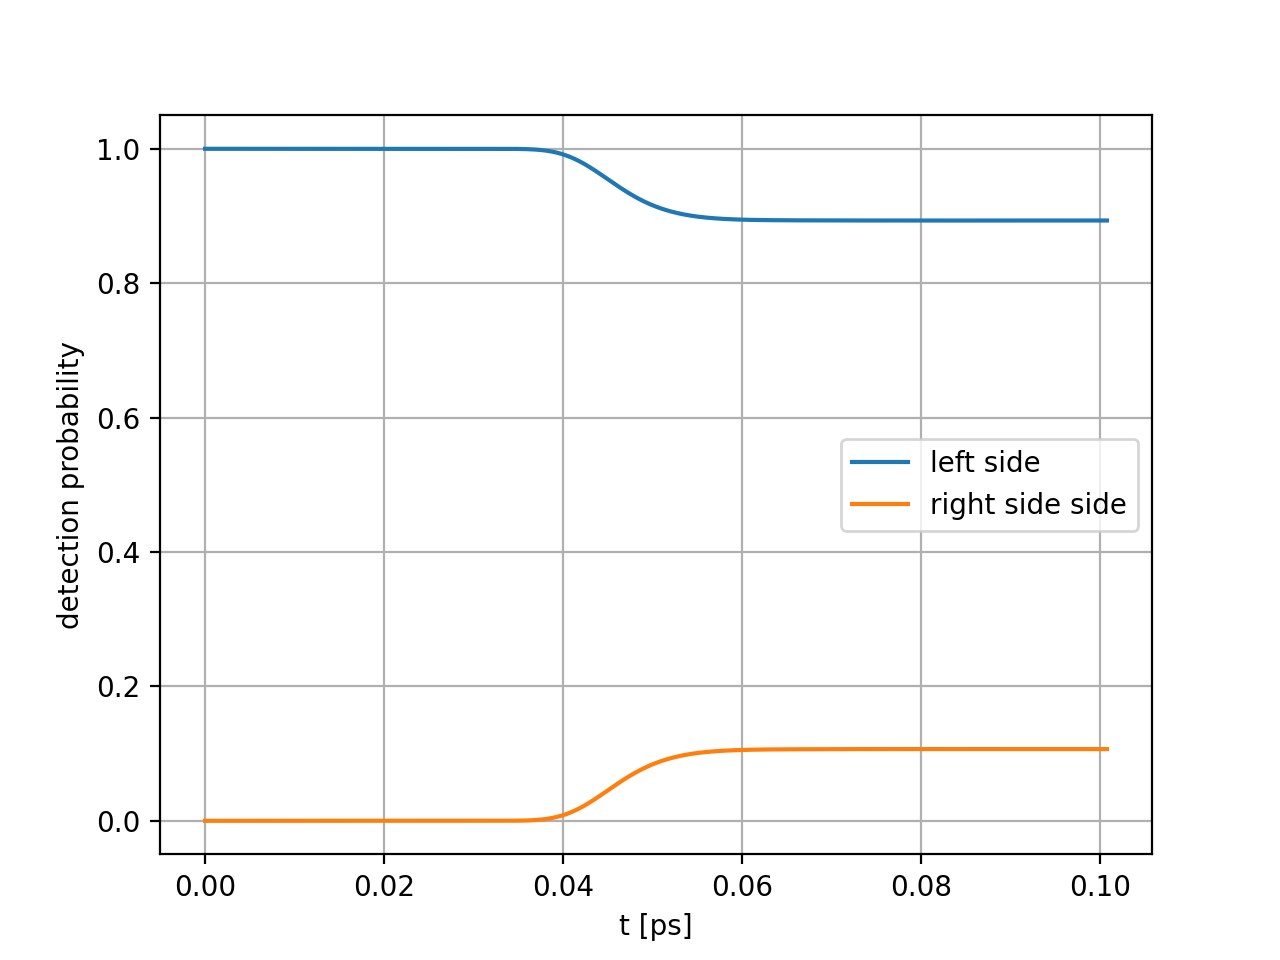

In [31]:
# evaluate reflection and transmission by integrating the probality density on the left and right side of the potential barrrier.

left = np.sum(Psi2[:,:x_nmax//2], axis=1)*dx # integrate probility density on the left side
right = np.sum(Psi2[:,x_nmax//2:], axis=1)*dx # integrate probility density on the right side

plt.grid()
plt.plot(t*1e12,left, label='left side')
plt.plot(t*1e12,right, label='right side side')
plt.legend()
plt.xlabel('t [ps]')
plt.ylabel('detection probability')
plt.show()